### Import necessary libraries

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil as su
import random as rd
import cv2

## Load data

In [72]:
%%bash
mkdir -p tmp_data
rm -rf tmp_data/*
mkdir -p tmp_data/train_set
mkdir -p tmp_data/test_set

## Separate training dataset

In [73]:
def separate_data(path, nb_elements=1):
    """
    Separate given data in `path` in two sets with `nb_elements` per class for test

    Parameters
    ----------
    path: str
        Path to directory where dataset files are stored.

    nb_elements: integer
        Defines the number of test images taken in each class of the dataset
    """
    labels_path = os.path.join(path, "labels.txt")
    images_path = path
    test_path = 'tmp_data/test_set'
    train_path = 'tmp_data/train_set'

    
    labels = np.empty((0, 1))
    names = np.empty((0, 1))
    with open(labels_path) as f:
        for current_label in f:
            if current_label == "\n":
                continue
            label, name = current_label.split(": ")
            labels = np.append(labels, label)
            names = np.append(names, name)

    for label in labels:
        pre_label = 'img_' + label + '_'
        curr_test_path = os.path.join(test_path, label)
        curr_train_path = os.path.join(train_path, label)
        os.makedirs(curr_test_path, exist_ok=True)
        os.makedirs(curr_train_path, exist_ok=True)

        current_path = os.path.join(images_path, label)
        datas = os.listdir(current_path)
        rd.shuffle(datas)

        count = 0
        for data in datas:
            data_path = os.path.join(current_path, data)
            if count < nb_elements:
                su.copyfile(data_path, os.path.join(curr_test_path, pre_label + str(count) + '.png'))
            else:
                su.copyfile(data_path, os.path.join(curr_train_path, pre_label + str(count - nb_elements) + '.png'))
            count += 1

    return labels, names

In [74]:
ref = separate_data('ressources/train', 2)

## Get separated datasets

In [75]:
def get_datasets(kind='train'):
    """
    Returns `kind` set and their label

    Parameters
    ----------
    kind: str (train or test)
        Type of dataset we want to get
    """
    assert kind == 'train' or kind == 'test'
    dataset_path = 'tmp_data/train_set' if kind == 'train' else 'tmp_data/test_set'
    
    images = []
    labels = []
    dirs = os.listdir(dataset_path)

    for folder in dirs : 
        curr_path = os.path.join(dataset_path, folder)
        datas = os.listdir(curr_path)
        for data in datas:
            data_path = os.path.join(curr_path, data)
            img = cv2.imread(data_path);
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
            images.append(img)
            labels.append(folder)
    
    return labels, images

In [76]:
train_labels, train_images = get_datasets('train')
test_labels, test_images = get_datasets('test')

## Shuffle datasets

In [77]:
def shuffle_set(labels, images):
    """
    Shuffles equally labels and images

    Parameters
    ----------
    labels: [str]
        Dataset's labels
        
    images: [image]
        Dataset's images
    """
    assert len(labels) == len(images)
    shuffle_index = np.arange(len(labels))
    np.random.shuffle(shuffle_index)
    new_labels = np.array(labels)
    new_images = np.array(images, dtype=object)
    
    for ii in range(shuffle_index.size):
        new_labels[ii] = labels[shuffle_index[ii]]
        new_images[ii] = images[shuffle_index[ii]]
        
    return new_labels, new_images

In [78]:
train_labels, train_images = shuffle_set(train_labels, train_images)
test_labels, test_images = shuffle_set(test_labels, test_images)

## Print train example

56
['ampoule\n']


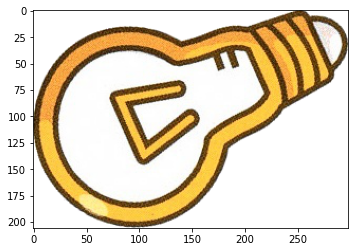

In [10]:
print(train_labels[0])
plt.imshow(train_images[0])
print(ref[1][np.where(ref[0] == train_labels[0])])

## Print test example

34
['chien\n']


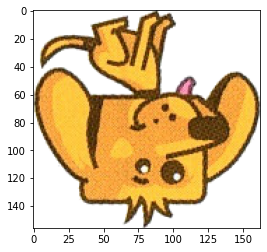

In [11]:
print(test_labels[0])
plt.imshow(test_images[0])
print(ref[1][np.where(ref[0] == test_labels[0])])

## Summary

If you executed all of the above, you defined the following variables:

```python
ref # couple:
    ref[0] # labels' identifiers
    ref[1] # labels

train_labels # train dataset's images' identifiers for labels

train_images # train dataset's images

test_labels # test dataset's images' identifiers for labels

test_images # test dataset's images
```

## Color histogram
#### 1. Color quantization

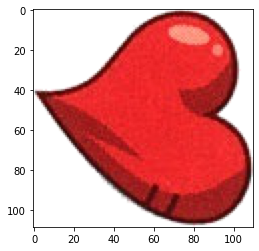

In [15]:
def get_each_image() :
    """
    Return one image of each type with corresponding labels
    """
    PATH_TO_RESOURCES = "ressources/train"
    images = []
    dirs = os.listdir(PATH_TO_RESOURCES)
    labels = []
    for name_dir in dirs : 
        if name_dir == "labels.txt" :
            continue
        actual_path = os.path.join(PATH_TO_RESOURCES, name_dir)
        img_name = os.listdir(actual_path)[0]
        img = cv2.imread(os.path.join(actual_path, img_name));
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
        images.append(img)
        labels.append(name_dir)
    return images, labels

each_images, each_labels = get_each_image()
plt.imshow(each_images[52])

(250, 14250, 3)

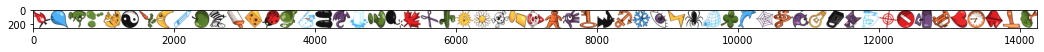

In [16]:
def create_poster(images) : 
    """
    Return a poster containing all images and a corresponding mask
    
    Parameters
    ----------        
    images: [image]
        Dataset's images
    """
    sizeImg = 250
    img0 = cv2.resize(images[0], (sizeImg, sizeImg))
    poster = img0
    first = True
    for img in images : 
        if first : 
            first = False
            continue
        img = cv2.resize(img, (sizeImg, sizeImg))
        poster = cv2.hconcat([poster, img])
    
    # Create a mask for the poster generated 
    poster_mask = np.zeros(poster.shape[0] * poster.shape[1])
    for i in range(poster.shape[0]) : 
        for j in range(poster.shape[1]) : 
            poster_mask[i * poster.shape[0] +  j] = np.all(poster[i, j] != 255)
    
    return poster, poster_mask

poster, poster_mask = create_poster(each_images)
plt.figure(figsize=(18,18))
plt.imshow(poster)
poster.shape

In [66]:
from sklearn.cluster import KMeans

def train_kmeans(poster, nb_colors) :
    """
    'Train' kmeans using poster's colors 
    Parameters
    ----------
    poster: image
        
    nb_colors: int
        Number of clusters for kmeans
    """
    plane_poster = poster.reshape(len(poster) * len(poster[0]), 3)
    kmeans = KMeans(n_clusters=nb_colors, random_state=0)
    kmeans.fit(plane_poster)
    kmeans.cluster_centers_
    label_map = kmeans.predict(plane_poster)
    return kmeans, label_map

kmeans, label_map = train_kmeans(poster, 10)

<BarContainer object of 10 artists>

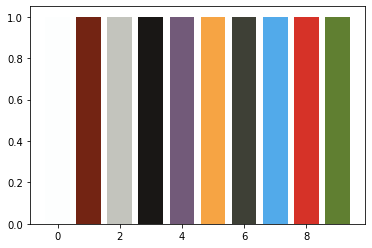

In [67]:
color_lut = np.uint8(kmeans.cluster_centers_)
plt.bar(np.arange(len(color_lut)), 
         np.ones(len(color_lut)), 
         color=color_lut/255)

### 2. Color histograms

In [68]:
def reduce_color(img, kmeans) : 
    """
    Reduce the colors in an image
    
    Parameters
    ----------
    img: image
        Reference image
    kmeans: Kmeans
        kmeans used to determine new colors
    """
    newImg = np.zeros_like((0, 0, 0), shape=img.shape)
    prediction = kmeans.predict(img.reshape(len(img) * len(img[0]), 3))
    histo = np.zeros(len(kmeans.cluster_centers_))
    for i in range(len(img)) : 
        for j in range(len(img[0])) :
            if img[i, j][0] == 255 and img[i, j][1] == 255 and img[i, j][2] == 255: 
                newImg[i, j] = [255, 255,255]
            else :
                newImg[i, j] = kmeans.cluster_centers_[prediction[i * len(img[0]) + j]]
                histo[prediction[i * len(img[0]) + j]] += 1
    return newImg, histo

def normalize_histogram(histo) : 
    """
    Normalize histogram
    
    Parameter
    ----------
    histo: [int]
        image histogram
    """
    nbPixels = np.sum(histo)
    for i in range(len(histo)) : 
        if histo[i] != 0 :
            histo[i] = histo[i] / nbPixels
    return histo

In [69]:
# Reduce color of all images
images_quant = []
color_histograms = []
for i in range(len(each_images)) : 
    newImg, histo = reduce_color(each_images[i], kmeans)
    images_quant.append(newImg)
    # Normalise histogram
    histo = normalize_histogram(histo)
    color_histograms.append(histo) 

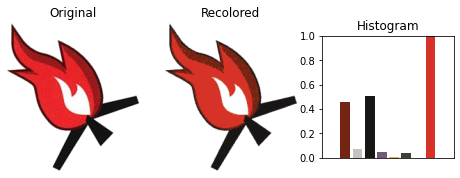

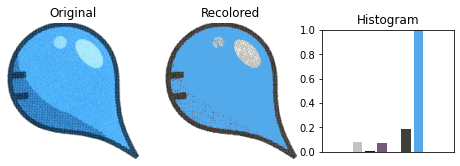

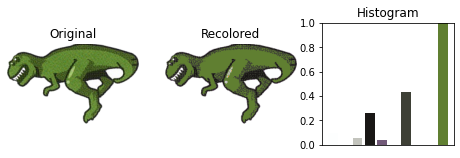

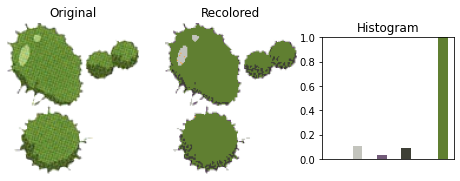

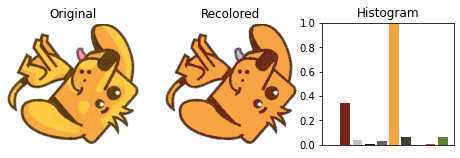

In [70]:
# Show some color histograms with colors!
colors_for_bars = color_lut/255  # matplotlib colors are RGB values scaled to [0,1]
for ii in range(5):
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(each_images[ii])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(images_quant[ii])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[ii])), 
            color_histograms[ii]/color_histograms[ii].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

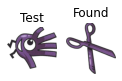

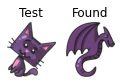

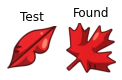

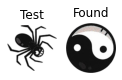

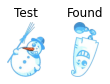

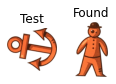

Accuracy:  0.9473684210526315


In [79]:
import scipy as sc

good_result = 0
for i in range(len(test_images)) : 
    test_img = test_images[i]
    test_img_recolored, test_histo = reduce_color(test_img, kmeans)
    test_histo = normalize_histogram(test_histo)
    minimal_distance = sc.spatial.distance.pdist(np.vstack((test_histo, color_histograms[0])))
    best_index = 0
    
    for j in range(1, len(color_histograms)) :
        dist = sc.spatial.distance.pdist(np.vstack((test_histo, color_histograms[j])))
        if dist < minimal_distance : 
            minimal_distance = dist 
            best_index = j
    # Check que le result est bon
    if test_labels[i] == each_labels[best_index] :
        good_result += 1
    else :
        plt.figure(figsize=(3,1))
        plt.subplot(1,3, 1)
        plt.imshow(test_img)
        plt.axis('off'); plt.title("Test")
        plt.subplot(1,3,2)
        plt.imshow(each_images[best_index])
        plt.axis('off'); plt.title("Found")
        plt.show()
    
accuracy = good_result / len(test_images)
print("Accuracy: ", accuracy)

In [82]:
len(test_images)

114